In [30]:
# Import Libraries

import pandas as pd
import numpy as np
import nltk
import re
import unicodedata
import seaborn as sns
import pickle
import tensorflow_hub as hub
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from autocorrect import Speller
from spacy.lang.es.stop_words import STOP_WORDS
import spacy

# Load spaCy language model
nlp = spacy.load('en_core_web_sm')

# Ignore warning messages
import warnings
warnings.filterwarnings('ignore')

# Tokenization function
tokenizer = word_tokenize
stopword_list = nltk.corpus.stopwords.words('english')

# Spell checker
spell_checker = Speller(lang='en')

# Set Pandas display options
pd.set_option('display.max_colwidth', 1000)


In [31]:
# Function to clean chars - emoticons
def remove_accented_chars(text):
    # En particular, NFKD significa "Normalización de Forma Canónica Descomposición de Compatibilidad
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


def normalize_corpus(corpus, accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True,spell_correction=True):
    doc = corpus
    # accented characters removal
    if accented_char_removal:
        doc = remove_accented_chars(doc)
    
    # lowercase text
    if text_lower_case:
        doc = doc.lower()
    
    doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
    
    # lemmatize text
    if text_lemmatization:
        doc = lemmatize_text(doc)
    
    # remove special characters and\or digits    
    if special_char_removal:
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        doc = remove_special_characters(doc, remove_digits=remove_digits)  
    
    # remove extra whitespace
    doc = re.sub(' +', ' ', doc)
    
    # remove stopwords
    if stopword_removal:
        doc = remove_stopwords(doc, is_lower_case=text_lower_case)
    
#     # spell correction
#     if spell_correction:
#         tokens = tokenizer(doc)
#         total_tokens = len(tokens)
#         corrected_tokens = []
#         for token in tqdm(tokens, desc="Applying Spell Correction", total=total_tokens):
#             corrected_token = spell_checker(token)
#             corrected_tokens.append(corrected_token)
#         doc = ' '.join(corrected_tokens)
        
#     if spell_correction:
#         tokens = tokenizer(doc)
#         corrected_tokens = [spell_checker(word) for word in tokens]
#         doc = ' '.join(corrected_tokens)  


    return doc


def clean(text):
    doc = re.sub(r'[\W_]', ' ', text) # removing underscores
    doc = normalize_corpus(doc, text_lemmatization=False)
    return doc

In [32]:
# Load movies review data 
model_url = 'https://tfhub.dev/google/universal-sentence-encoder/4'
model = hub.load(model_url)

In [33]:
df = pd.read_csv('data_imdb.csv',encoding= 'unicode_escape')[['Name of movie','Description']]
#df = pd.read_csv('reviews.csv')[['movie','content']]

In [34]:
df.shape

(100, 2)

In [35]:
df

,Name of movie,Description
0,The Shawshank Redemption,"Over the course of several years, two convicts form a friendship, seeking consolation and, eventually, redemption through basic compassion."
1,The Godfather,"Don Vito Corleone, head of a mafia family, decides to hand over his empire to his youngest son Michael. However, his decision unintentionally puts the lives of his loved ones in grave danger."
2,Spider-Man: Across the Spider-Verse,"Miles Morales catapults across the Multiverse, where he encounters a team of Spider-People charged with protecting its very existence. When the heroes clash on how to handle a new threat, Miles must redefine what it means to be a hero."
3,The Dark Knight,"When the menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman must accept one of the greatest psychological and physical tests of his ability to fight injustice."
4,Schindler's List,"In German-occupied Poland during World War II, industrialist Oskar Schindler gradually becomes concerned for his Jewish workforce after witnessing their persecution by the Nazis."
...,...,...
95,Scarface,"In 1980 Miami, a determined Cuban immigrant takes over a drug cartel and succumbs to greed."
96,American Beauty,A sexually frustrated suburban father has a mid-life crisis after becoming infatuated with his daughter's best friend.
97,North by Northwest,"A New York City advertising executive goes on the run after being mistaken for a government agent by a group of foreign spies, and falls for a woman whose loyalties he begins to doubt."
98,2001: A Space Odyssey,"After uncovering a mysterious artifact buried beneath the Lunar surface, a spacecraft is sent to Jupiter to find its origins - a spacecraft manned by two men and the supercomputer H.A.L. 9000."


In [36]:
df['cleaned'] = df['Description'].apply(clean)

In [48]:
description = list(df['cleaned'])

In [49]:
df.head(5)

,Name of movie,Description,cleaned
0,The Shawshank Redemption,"Over the course of several years, two convicts form a friendship, seeking consolation and, eventually, redemption through basic compassion.",course several years two convicts form friendship seeking consolation eventually redemption basic compassion
1,The Godfather,"Don Vito Corleone, head of a mafia family, decides to hand over his empire to his youngest son Michael. However, his decision unintentionally puts the lives of his loved ones in grave danger.",vito corleone head mafia family decides hand empire youngest son michael however decision unintentionally puts lives loved ones grave danger
2,Spider-Man: Across the Spider-Verse,"Miles Morales catapults across the Multiverse, where he encounters a team of Spider-People charged with protecting its very existence. When the heroes clash on how to handle a new threat, Miles must redefine what it means to be a hero.",miles morales catapults across multiverse encounters team spider people charged protecting existence heroes clash handle new threat miles must redefine means hero
3,The Dark Knight,"When the menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman must accept one of the greatest psychological and physical tests of his ability to fight injustice.",menace known joker wreaks havoc chaos people gotham batman must accept one greatest psychological physical tests ability fight injustice
4,Schindler's List,"In German-occupied Poland during World War II, industrialist Oskar Schindler gradually becomes concerned for his Jewish workforce after witnessing their persecution by the Nazis.",german occupied poland world war ii industrialist oskar schindler gradually becomes concerned jewish workforce witnessing persecution nazis


In [50]:
embedding = model(description)

In [51]:
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embedding)

In [52]:
emb_2d

array([[-0.24578476,  0.27893461],
       [-0.02910358, -0.26975094],
       [ 0.40921407,  0.01577719],
       [ 0.25197555, -0.02972199],
       [ 0.07348514, -0.01848205],
       [-0.15770083, -0.24505022],
       [ 0.59686922,  0.15520006],
       [-0.04637867, -0.25894889],
       [-0.13046823, -0.14008539],
       [ 0.05362887,  0.12841045],
       [ 0.48728985,  0.21403534],
       [-0.01960996,  0.12041922],
       [-0.08833236,  0.0129539 ],
       [ 0.01425057, -0.13142402],
       [ 0.51811543,  0.16153605],
       [-0.19177306, -0.09089837],
       [-0.03620477, -0.12320669],
       [-0.08842681,  0.24954862],
       [ 0.14915354,  0.11059936],
       [-0.18426091, -0.0315221 ],
       [-0.06139676,  0.11444127],
       [-0.16017632, -0.14776737],
       [ 0.41153282, -0.11006585],
       [ 0.06956201,  0.00688346],
       [-0.09427642, -0.20270306],
       [ 0.13747144, -0.06725701],
       [-0.1866287 , -0.16346682],
       [-0.22401902, -0.17551406],
       [ 0.39150105,

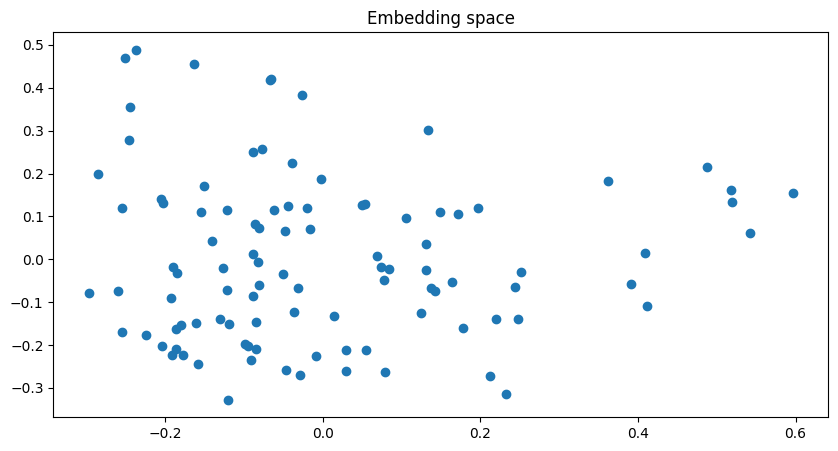

In [53]:
plt.figure(figsize=(10,5))
plt.title("Embedding space")
plt.scatter(emb_2d[:,0],emb_2d[:,1])
plt.show()

In [54]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(embedding)

NearestNeighbors()

In [55]:
def detectmovie(descriptionText):
    emd = model([descriptionText])
    neighbours = nn.kneighbors(emd,return_distance=False)[0]
    print(neighbours)
    return df['Name of movie'].iloc[neighbours].tolist()

In [56]:
detectmovie('the film is about a man who was bitten by a spider and gave him powers')

[59 79 14  2 65]


['Spider-Man: Into the Spider-Verse',
 'Sunset Blvd.',
 'The Lord of the Rings: The Two Towers',
 'Spider-Man: Across the Spider-Verse',
 'Avengers: Infinity War']